In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Populating the interactive namespace from numpy and matplotlib


### Test case 1 (parallel conduits, head gradient boundary)

In [2]:
mg = RasterModelGrid((5,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

#mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] =  mg.at_link['width'].copy()

#mg.at_node['input__discharge'][12]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

flow_bnd = False
for i in arange(300):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=5., normal_flow_bnd = flow_bnd)
    if i==5:
        flow_bnd=True
    


Number of links =  85
Number of nodes =  50
Number of active links =  43
Number of core nodes =  24
Time iteration: 0
max change in h:  0.20008413037
max change in h:  0.104353194123
max change in h:  0.0472084909572
max change in h:  0.0185036485488
max change in h:  0.00967358159766
max change in h:  0.00750198366936
max change in h:  0.00527242653576
max change in h:  0.00345981028981
max change in h:  0.00216174873603
max change in h:  0.00130389134077
max change in h:  0.000767124151536
max change in h:  0.00044385834147
max change in h:  0.000254256260514
max change in h:  0.000147514096285
max change in h:  9.29461022184e-05
average dh= 0.0842502876349   average abs(dQ)= 0.277032084171
Time iteration: 1
max change in h:  0.354279403299
max change in h:  0.151754388777
max change in h:  0.0605764185522
max change in h:  0.0227469314879
max change in h:  0.0132167167938
max change in h:  0.00704536625751
max change in h:  0.00351367126074
max change in h:  0.00165593798546
max cha

max change in h:  0.000531655630295
max change in h:  0.000257759081226
max change in h:  0.000124862946951
max change in h:  6.08604436545e-05
average dh= 0.0489772568563   average abs(dQ)= 0.00924758040136
Time iteration: 31
max change in h:  0.0182576265734
max change in h:  0.00894364395055
max change in h:  0.0043633980958
max change in h:  0.00212212571332
max change in h:  0.00102965957758
max change in h:  0.000498767458642
max change in h:  0.000242271015122
max change in h:  0.00011804455974
max change in h:  5.79017348104e-05
average dh= 0.0465510705602   average abs(dQ)= 0.00856738463829
Time iteration: 32
max change in h:  0.0172203970176
max change in h:  0.00842498839537
max change in h:  0.00410522820049
max change in h:  0.00199423462132
max change in h:  0.000966642385897
max change in h:  0.000471090589373
max change in h:  0.000230100610833
max change in h:  0.000113094342382
max change in h:  5.55212278881e-05
average dh= 0.0442369803099   average abs(dQ)= 0.007968

max change in h:  0.00302426428366
max change in h:  0.00148601318528
max change in h:  0.000728299133485
max change in h:  0.000356241871453
max change in h:  0.000173997263002
max change in h:  8.5137410033e-05
average dh= 0.00784402927279   average abs(dQ)= 0.00137281077191
Time iteration: 67
max change in h:  0.0028681265654
max change in h:  0.00140914259966
max change in h:  0.000690672947115
max change in h:  0.000338007007637
max change in h:  0.000165630620503
max change in h:  8.10800849447e-05
average dh= 0.00745883447551   average abs(dQ)= 0.00131139916486
Time iteration: 68
max change in h:  0.00271797718777
max change in h:  0.00133761831611
max change in h:  0.00065704083206
max change in h:  0.000322176247084
max change in h:  0.000157756457996
max change in h:  7.71585329229e-05
average dh= 0.0070924454489   average abs(dQ)= 0.00124852586201
Time iteration: 69
max change in h:  0.00259241586209
max change in h:  0.00127577345994
max change in h:  0.000626306851341
max 

max change in h:  8.18107549527e-05
average dh= 0.000883587604815   average abs(dQ)= 0.00015743768485
Time iteration: 111
max change in h:  0.000323493353247
max change in h:  0.000158960240624
max change in h:  7.79257426835e-05
average dh= 0.000842303027617   average abs(dQ)= 0.000150901481659
Time iteration: 112
max change in h:  0.000307980828383
max change in h:  0.000151316934712
max change in h:  7.41750419664e-05
average dh= 0.000802897624812   average abs(dQ)= 0.000144426125014
Time iteration: 113
max change in h:  0.00029300699352
max change in h:  0.000143962084518
max change in h:  7.06227903784e-05
average dh= 0.00076530940533   average abs(dQ)= 0.000137958634022
Time iteration: 114
max change in h:  0.000279290771581
max change in h:  0.000137382946022
max change in h:  6.74293146403e-05
average dh= 0.000729468031031   average abs(dQ)= 0.000131494246929
Time iteration: 115
max change in h:  0.000266726335569
max change in h:  0.000131165788143
max change in h:  6.43525811

max change in h:  7.52066121024e-06
average dh= 1.83787144415e-05   average abs(dQ)= 3.46023999747e-06
Time iteration: 206
max change in h:  7.17510734827e-06
average dh= 1.76783279489e-05   average abs(dQ)= 3.52052636535e-06
Time iteration: 207
max change in h:  6.77500470658e-06
average dh= 1.70046318719e-05   average abs(dQ)= 3.54493159952e-06
Time iteration: 208
max change in h:  6.34072980876e-06
average dh= 1.63566091745e-05   average abs(dQ)= 3.51260410017e-06
Time iteration: 209
max change in h:  6.05221526939e-06
average dh= 1.57332815726e-05   average abs(dQ)= 3.4115027409e-06
Time iteration: 210
max change in h:  6.0177047212e-06
average dh= 1.51337080293e-05   average abs(dQ)= 3.24002204364e-06
Time iteration: 211
max change in h:  5.95260183456e-06
average dh= 1.45569833278e-05   average abs(dQ)= 3.00713518074e-06
Time iteration: 212
max change in h:  5.83504173512e-06
average dh= 1.40022367183e-05   average abs(dQ)= 2.73104042388e-06
Time iteration: 213
max change in h:  

Node net fluxes =  [  7.98249786e-07   1.48142909e-06   1.95102569e-06   2.13927806e-06
   2.01896170e-06   1.60735086e-06   9.63758028e-07   1.81591721e-07
   5.32509364e-07   9.88629306e-07   1.30292887e-06   1.43032181e-06
   1.35253420e-06   1.08072559e-06   6.53884451e-07   1.33523967e-07
   2.67280242e-07   4.96780613e-07   6.56089757e-07   7.22753483e-07
   6.87429594e-07   5.55171066e-07   3.44676970e-07   8.56229607e-08]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           8.86898429   7.73796913   6.60695503   5.4759423
   4.34493108   3.21392128   2.08291263   0.95190466   0.
  10.           8.86898304   7.73796683   6.60695199   5.47593895
   4.3449279    3.21391874   2.08291107   0.95190431   0.
  10.           8.8689818    7.73796452   6.60694895   5.47593561
   4.34492473   3.21391619   2.0829095    0.95190395   0.
  10.           0.           0.           0.           0.
   0.   

Text(0, 0.5, 'D_H')

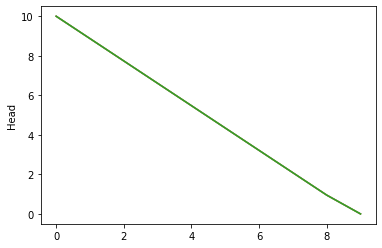

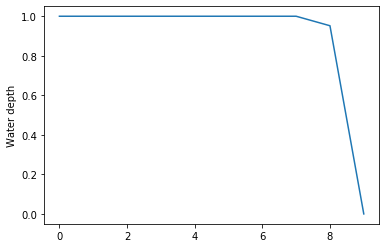

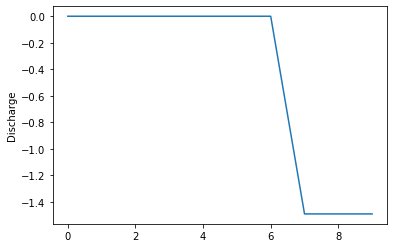

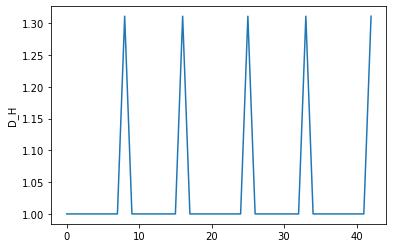

In [3]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",h)

figure()
plot(h[10:20])
plot(h[20:30])
plot(h[30:40])
ylabel('Head')

print('Discharge=',Q[mg.active_links])
#Discharge from DW equation
L = max(mg.node_x)
deltaH = max(h[mg.nodes_at_left_edge]) - min(h[mg.nodes_at_right_edge])
f=0.1
g=9.8
D_H = 1. 
print('DW discharge = ', D_H**2.*sqrt(2*g*D_H*deltaH/f/L))


figure()
water_depth = mg.at_node['hydraulic__head'][10:20] - mg.at_node['junction__elevation'][10:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links][10:20])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')



Normal flow boundary fails in this case, as there is zero slope. Outfall (or fixed head) might be more appropriate here.

### Test Case 2 (single conduit, recharge boundary)

In [4]:
mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

#mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=1.475

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.1#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=10.,normal_flow_bnd=True)
    


Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
max change in h:  0.321679065747
max change in h:  0.109701065067
max change in h:  0.0808589219849
max change in h:  0.0410133142662
max change in h:  0.0148137304748
max change in h:  0.00447814162762
max change in h:  0.00305681428719
max change in h:  0.00204206949273
max change in h:  0.00114771343805
max change in h:  0.000573343627334
max change in h:  0.000265256520835
max change in h:  0.000118107299547
max change in h:  5.23104733321e-05
average dh= 0.190625384196   average abs(dQ)= 0.175424135459
Time iteration: 1
max change in h:  0.161957322706
max change in h:  0.0737699080751
max change in h:  0.0493572683458
max change in h:  0.0266243234852
max change in h:  0.0111963317351
max change in h:  0.00385898916629
max change in h:  0.00234721650336
max change in h:  0.00147615904684
max change in h:  0.000852337601309
max change in h:  0.000463802321318
max cha

max change in h:  0.000113984398027
max change in h:  5.60532629255e-05
average dh= 0.039756467384   average abs(dQ)= 0.00760963580763
Time iteration: 36
max change in h:  0.0157086449444
max change in h:  0.00775494924541
max change in h:  0.00382214019846
max change in h:  0.00188202230018
max change in h:  0.000926209897575
max change in h:  0.000455680843775
max change in h:  0.000224148140902
max change in h:  0.000110246342315
max change in h:  5.42208074119e-05
average dh= 0.0384439038979   average abs(dQ)= 0.00730575038189
Time iteration: 37
max change in h:  0.0151863602726
max change in h:  0.00749776413622
max change in h:  0.00369573819772
max change in h:  0.00181996458458
max change in h:  0.000895760329143
max change in h:  0.0004407451294
max change in h:  0.000216823397781
max change in h:  0.000106654533985
max change in h:  5.24596186731e-05
average dh= 0.0371834593417   average abs(dQ)= 0.00701805008311
Time iteration: 38
max change in h:  0.0146850152472
max change

max change in h:  0.000935455159288
max change in h:  0.000461542832927
max change in h:  0.000227606045785
max change in h:  0.000112208985142
max change in h:  5.530899492e-05
average dh= 0.00946750472681   average abs(dQ)= 0.00156020887054
Time iteration: 83
max change in h:  0.0037215084438
max change in h:  0.00184040870204
max change in h:  0.000908824074051
max change in h:  0.000448410521606
max change in h:  0.000221133568573
max change in h:  0.000109019878009
max change in h:  5.3737943901e-05
average dh= 0.00919844226707   average abs(dQ)= 0.00151398174063
Time iteration: 84
max change in h:  0.00361559477586
max change in h:  0.00178805453482
max change in h:  0.000882983703683
max change in h:  0.000435667709706
max change in h:  0.000214852852103
max change in h:  0.000105925150077
max change in h:  5.22133350174e-05
average dh= 0.00893734193328   average abs(dQ)= 0.00146923261144
Time iteration: 85
max change in h:  0.00351282393137
max change in h:  0.00173725251755
ma

max change in h:  0.000753614945765
max change in h:  0.000372790328505
max change in h:  0.000184154495876
max change in h:  9.08967102191e-05
average dh= 0.00186805817846   average abs(dQ)= 0.000303984600514
Time iteration: 141
max change in h:  0.000733429375298
max change in h:  0.000362805210257
max change in h:  0.000179222188271
max change in h:  8.84623487813e-05
average dh= 0.00181804582634   average abs(dQ)= 0.000295967480573
Time iteration: 142
max change in h:  0.000713780268928
max change in h:  0.000353085863896
max change in h:  0.000174421268671
max change in h:  8.60928615314e-05
average dh= 0.00176936251711   average abs(dQ)= 0.000288058497029
Time iteration: 143
max change in h:  0.000694658196979
max change in h:  0.000343627368641
max change in h:  0.000169749237958
max change in h:  8.37869969601e-05
average dh= 0.00172198365079   average abs(dQ)= 0.000280319566138
Time iteration: 144
max change in h:  0.000676050954448
max change in h:  0.000334423587146
max chan

max change in h:  0.000121553418829
max change in h:  6.00467144984e-05
average dh= 0.0006098546168   average abs(dQ)= 0.000100775878736
Time iteration: 183
max change in h:  0.000239384144216
max change in h:  0.000118411934256
max change in h:  5.84948862432e-05
average dh= 0.000594095254624   average abs(dQ)= 9.81649654274e-05
Time iteration: 184
max change in h:  0.00023319765894
max change in h:  0.000115351857481
max change in h:  5.69832693511e-05
average dh= 0.000578744184697   average abs(dQ)= 9.56220389931e-05
Time iteration: 185
max change in h:  0.000227171475441
max change in h:  0.000112371068067
max change in h:  5.55108165639e-05
average dh= 0.000563790774488   average abs(dQ)= 9.31453118837e-05
Time iteration: 186
max change in h:  0.000221301418907
max change in h:  0.000109467501296
max change in h:  5.40765081229e-05
average dh= 0.000549224671258   average abs(dQ)= 9.0733044243e-05
Time iteration: 187
max change in h:  0.000215583424245
max change in h:  0.000106639

max change in h:  4.71437870839e-05
average dh= 0.000117545297289   average abs(dQ)= 2.01095624013e-05
Time iteration: 255
max change in h:  4.61628463064e-05
average dh= 0.000115099551143   average abs(dQ)= 1.96909402221e-05
Time iteration: 256
max change in h:  4.52023271311e-05
average dh= 0.000112704719134   average abs(dQ)= 1.92810423819e-05
Time iteration: 257
max change in h:  4.42618039891e-05
average dh= 0.000110359739529   average abs(dQ)= 1.8879685397e-05
Time iteration: 258
max change in h:  4.33408602198e-05
average dh= 0.000108063573705   average abs(dQ)= 1.84866902877e-05
Time iteration: 259
max change in h:  4.24390878386e-05
average dh= 0.000105815205035   average abs(dQ)= 1.81018829179e-05
Time iteration: 260
max change in h:  4.1556087357e-05
average dh= 0.000103613637758   average abs(dQ)= 1.77250929295e-05
Time iteration: 261
max change in h:  4.06914676212e-05
average dh= 0.00010145789658   average abs(dQ)= 1.73561530058e-05
Time iteration: 262
max change in h:  3

max change in h:  7.73234096663e-06
average dh= 1.92797874038e-05   average abs(dQ)= 3.29699209789e-06
Time iteration: 341
max change in h:  7.57152369601e-06
average dh= 1.88788081289e-05   average abs(dQ)= 3.22841604361e-06
Time iteration: 342
max change in h:  7.41405139237e-06
average dh= 1.84861690726e-05   average abs(dQ)= 3.16126657263e-06
Time iteration: 343
max change in h:  7.25985447225e-06
average dh= 1.81016967329e-05   average abs(dQ)= 3.09551399807e-06
Time iteration: 344
max change in h:  7.10886479638e-06
average dh= 1.77252212188e-05   average abs(dQ)= 3.03112925179e-06
Time iteration: 345
max change in h:  6.96101564657e-06
average dh= 1.73565761743e-05   average abs(dQ)= 2.96808387004e-06
Time iteration: 346
max change in h:  6.81624168486e-06
average dh= 1.69955987053e-05   average abs(dQ)= 2.90634998293e-06
Time iteration: 347
max change in h:  6.67447894287e-06
average dh= 1.66421293075e-05   average abs(dQ)= 2.84590030003e-06
Time iteration: 348
max change in h:

max change in h:  1.19119906827e-06
average dh= 2.97014276216e-06   average abs(dQ)= 5.07882021522e-07
Time iteration: 430
max change in h:  1.16642636527e-06
average dh= 2.90837440241e-06   average abs(dQ)= 4.97319758902e-07
Time iteration: 431
max change in h:  1.14216885372e-06
average dh= 2.84789062026e-06   average abs(dQ)= 4.86977161818e-07
Time iteration: 432
max change in h:  1.11841581862e-06
average dh= 2.78866470008e-06   average abs(dQ)= 4.76849661646e-07
Time iteration: 433
max change in h:  1.09515676705e-06
average dh= 2.73067048178e-06   average abs(dQ)= 4.66932784521e-07
Time iteration: 434
max change in h:  1.07238142633e-06
average dh= 2.67388234946e-06   average abs(dQ)= 4.57222150446e-07
Time iteration: 435
max change in h:  1.05007973872e-06
average dh= 2.61827521999e-06   average abs(dQ)= 4.47713469048e-07
Time iteration: 436
max change in h:  1.02824185255e-06
average dh= 2.56382453194e-06   average abs(dQ)= 4.38402540964e-07
Time iteration: 437
max change in h:

Node net fluxes =  [  1.08785817e-06   1.04335798e-06   9.56177981e-07   8.29884453e-07
   6.69643590e-07   4.82010850e-07   2.74646442e-07   5.64118096e-08]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           8.70842856   7.59954891   6.49067078   5.38179405
   4.27291854   3.164044     2.05517017   0.94629674   0.
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Discharge= [-1.47499891 -1.47499787 -1.47499691 -1.47499608 -1.47499541 -1.47499493
 -1.47499466 -1.4749946 ]
DW discharge =  1.47572957475


Text(0, 0.5, 'D_H')

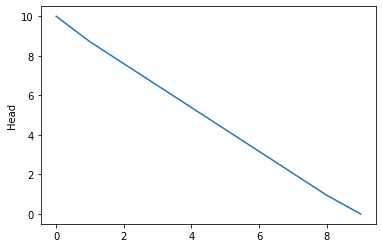

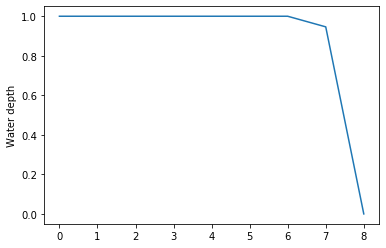

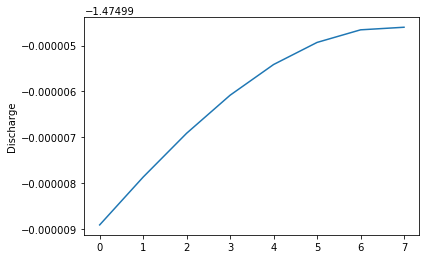

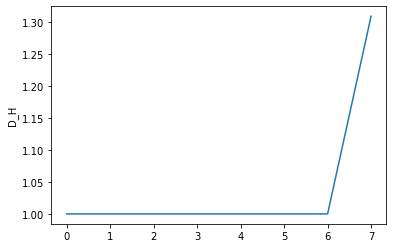

In [5]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",h)

figure()
plot(h[10:20])
#plot(h[20:30])
#plot(h[30:40])
ylabel('Head')

print('Discharge=',Q[mg.active_links])
#Discharge from DW equation
L = max(mg.node_x)
deltaH = max(h[mg.nodes_at_left_edge]) - min(h[mg.nodes_at_right_edge])
f=0.1
g=9.8
D_H = 1. 
print('DW discharge = ', D_H**2.*sqrt(2*g*D_H*deltaH/f/L))

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')




### Test Case 3 (Single conduit, Recharge boundary, slightly tilted domain)

In [4]:
### Note need to add downstream boundary condition for critical flow depth (free outfall)

#For rectangle, Y_crit = (Q^2/(g w^2))^(1/3)



mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.0001*mg.node_x + 0.09
#mg.at_node['hydraulic__head'] = mg.at_node['junction__elevation'] + 1
#h = mg.at_node['hydraulic__head']


w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=0.1#.475

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.0


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

flow_bnd=False
for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=10., normal_flow_bnd=flow_bnd)
    if i==5:
        flow_bnd=True


Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
max change in h:  0.0249999938688
max change in h:  0.012499999997
max change in h:  0.00616953118155
max change in h:  0.00299654264292
max change in h:  0.00143257459229
max change in h:  0.000675200883168
max change in h:  0.000314277829414
max change in h:  0.00014471360585
max change in h:  6.60310847718e-05
average dh= 0.0125   average abs(dQ)= 0.000161938674709
Time iteration: 1
max change in h:  0.0235142434261
max change in h:  0.0106602825628
max change in h:  0.00456274031329
max change in h:  0.00183243477067
max change in h:  0.000879274006347
max change in h:  0.00054943367248
max change in h:  0.000321903599531
max change in h:  0.000179210067982
max change in h:  9.56952656616e-05
average dh= 0.0125   average abs(dQ)= 0.00197918751757
Time iteration: 2
max change in h:  0.0177404001537
max change in h:  0.00730921038722
max change in h:  0.00348110583779
m

Entering normal flow calc.
slope= [ 0.0001]   Q= [ -1.87619872e-21]
max change in h:  0.00443041021707
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -2.81073615e-18]
max change in h:  0.00245480432593
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -6.40057970e-18]
max change in h:  0.00131606515738
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -1.07393220e-17]
max change in h:  0.000681494863746
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -1.51390859e-17]
max change in h:  0.000341380464806
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -1.91636361e-17]
max change in h:  0.000165997737684
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -2.25723254e-17]
max change in h:  7.87284095346e-05
average dh= 0.0125   average abs(dQ)= 0.00256653639552
Time iteration: 17
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -3.65786287e-17]
Entering normal flow calc.
slope= [ 0.0001]   Q= [ -5.92390462e-17]
max change in h:  0.0103862508998
Entering normal flow calc.
slop

y_norm= 0.11476634761335863
max change in h:  0.00456804746641
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.01016261]
equiv_upstream_flow_depth= [ 0.14187895]
f(a)= [-0.00032093]   f(b)= [  9.94736056e-05]
y_norm= 0.11757750483965411
max change in h:  0.00216237879455
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.01032383]
equiv_upstream_flow_depth= [ 0.14404133]
f(a)= [-0.0003159]   f(b)= [  9.94567716e-05]
y_norm= 0.11890267254709083
max change in h:  0.00101786920569
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.01039981]
equiv_upstream_flow_depth= [ 0.1450592]
f(a)= [-0.00031359]   f(b)= [  9.94487465e-05]
y_norm= 0.11952538992893814
max change in h:  0.000479259473832
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.01043561]
equiv_upstream_flow_depth= [ 0.14553846]
f(a)= [-0.00031252]   f(b)= [  9.94449439e-05]
y_norm= 0.11981847621331775
max change in h:  0.000226915875777
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.01045259]
equiv_upstream_flo

y_norm= 0.3072241498514515
max change in h:  0.00019325071073
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.03756101]
equiv_upstream_flow_depth= [ 0.31390012]
f(a)= [-0.00051093]   f(b)= [  9.28092266e-05]
y_norm= 0.30732509132817476
max change in h:  9.5614843751e-05
average dh= 0.00794272072847   average abs(dQ)= 0.000685584539645
Time iteration: 35
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.03859258]
equiv_upstream_flow_depth= [ 0.31399574]
f(a)= [-0.00054441]   f(b)= [  9.24088336e-05]
y_norm= 0.31375506115947804
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.03913027]
equiv_upstream_flow_depth= [ 0.3202087]
f(a)= [-0.00052762]   f(b)= [  9.21958324e-05]
y_norm= 0.3170952696492684
max change in h:  0.00304346950646
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.03938019]
equiv_upstream_flow_depth= [ 0.32325217]
f(a)= [-0.00051931]   f(b)= [  9.20958230e-05]
y_norm= 0.3186452671750265
max change in h:  0.00149415279449
Entering normal flow calc.
slope= [

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.05258431]
equiv_upstream_flow_depth= [ 0.39812448]
f(a)= [-0.0005245]   f(b)= [  8.59066778e-05]
y_norm= 0.39857771150967963
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.05290735]
equiv_upstream_flow_depth= [ 0.40164419]
f(a)= [-0.00051727]   f(b)= [  8.57329896e-05]
y_norm= 0.4004924714947802
max change in h:  0.00173387703708
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.05304692]
equiv_upstream_flow_depth= [ 0.40337807]
f(a)= [-0.00051332]   f(b)= [  8.56576186e-05]
y_norm= 0.4013192289251007
max change in h:  0.000861228241057
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.05312937]
equiv_upstream_flow_depth= [ 0.4042393]
f(a)= [-0.00051168]   f(b)= [  8.56129965e-05]
y_norm= 0.4018075287783999
max change in h:  0.000425229143776
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.05316159]
equiv_upstream_flow_depth= [ 0.40466453]
f(a)= [-0.00051068]   f(b)= [  8.55955414e-05]
y_norm= 0.4019983049097665
max 

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.06320391]
equiv_upstream_flow_depth= [ 0.46257083]
f(a)= [-0.00050173]   f(b)= [  7.96394798e-05]
y_norm= 0.46073873438463714
max change in h:  0.000170351516302
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.06323345]
equiv_upstream_flow_depth= [ 0.46274119]
f(a)= [-0.0005017]   f(b)= [  7.96204400e-05]
y_norm= 0.4609096328267956
max change in h:  8.14003933943e-05
average dh= 0.00465360616294   average abs(dQ)= 0.000541472062139
Time iteration: 55
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.06366092]
equiv_upstream_flow_depth= [ 0.46282259]
f(a)= [-0.00050957]   f(b)= [  7.93439737e-05]
y_norm= 0.4633810812371264
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.06393442]
equiv_upstream_flow_depth= [ 0.4654865]
f(a)= [-0.00050543]   f(b)= [  7.91661058e-05]
y_norm= 0.46496127201833104
max change in h:  0.00131537996251
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.06402184]
equiv_upstream_flow_depth= [ 0.46

y_norm= 0.5116315852504857
max change in h:  0.00012728138206
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07211325]
equiv_upstream_flow_depth= [ 0.51303548]
f(a)= [-0.00049397]   f(b)= [  7.34947938e-05]
y_norm= 0.5118448987503957
max change in h:  5.92503572646e-05
average dh= 0.00352947852947   average abs(dQ)= 0.000343629828918
Time iteration: 66
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07242102]
equiv_upstream_flow_depth= [ 0.51309213]
f(a)= [-0.00049888]   f(b)= [  7.32680700e-05]
y_norm= 0.5135961464051589
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07263523]
equiv_upstream_flow_depth= [ 0.51504209]
f(a)= [-0.00049638]   f(b)= [  7.31097027e-05]
y_norm= 0.5148144809649793
max change in h:  0.000957260741063
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07268513]
equiv_upstream_flow_depth= [ 0.51599935]
f(a)= [-0.00049426]   f(b)= [  7.30727411e-05]
y_norm= 0.5150982532240227
max change in h:  0.000485327406484
Entering normal flow calc.
slope=

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07865702]
equiv_upstream_flow_depth= [ 0.54935887]
f(a)= [-0.00048937]   f(b)= [  6.84662238e-05]
y_norm= 0.5489001929306733
max change in h:  0.000180323505006
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07858646]
equiv_upstream_flow_depth= [ 0.5495274]
f(a)= [-0.00048784]   f(b)= [  6.85227729e-05]
y_norm= 0.5485025549967492
max change in h:  0.000106613970954
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07868193]
equiv_upstream_flow_depth= [ 0.54963401]
f(a)= [-0.00048896]   f(b)= [  6.84462472e-05]
y_norm= 0.5490405684330417
max change in h:  4.49218305776e-05
average dh= 0.00269782217525   average abs(dQ)= 0.000301144914876
Time iteration: 77
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07884656]
equiv_upstream_flow_depth= [ 0.54966481]
f(a)= [-0.00049134]   f(b)= [  6.83140669e-05]
y_norm= 0.549968157002688
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.07907715]
equiv_upstream_flow_depth= [ 0.551

y_norm= 0.5743607982962304
max change in h:  0.000229697516812
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.08417318]
equiv_upstream_flow_depth= [ 0.57716918]
f(a)= [-0.00049244]   f(b)= [  6.38882517e-05]
y_norm= 0.579868955071082
max change in h:  3.82225996479e-05
average dh= 0.00201218781351   average abs(dQ)= 0.000365944308257
Time iteration: 88
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.08338918]
equiv_upstream_flow_depth= [ 0.57703197]
f(a)= [-0.00048182]   f(b)= [  6.45578217e-05]
y_norm= 0.5754810989198579
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.08451636]
equiv_upstream_flow_depth= [ 0.57822392]
f(a)= [-0.00049442]   f(b)= [  6.35931994e-05]
y_norm= 0.5817882182382498
max change in h:  0.000526510588771
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.08346058]
equiv_upstream_flow_depth= [ 0.57855729]
f(a)= [-0.00047878]   f(b)= [  6.44971052e-05]
y_norm= 0.5758808695257559
max change in h:  0.000454055048295
Entering normal flow calc.
slope=

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.20003626]
equiv_upstream_flow_depth= [ 0.40112642]
f(a)= [-0.00875487]   f(b)= [-0.00010395]
max change in h:  0.00031528932258
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.19646102]
equiv_upstream_flow_depth= [ 0.39615891]
f(a)= [-0.00873508]   f(b)= [ -9.67223844e-05]
max change in h:  0.000153121320466
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.19447013]
equiv_upstream_flow_depth= [ 0.39399215]
f(a)= [-0.00868687]   f(b)= [ -9.27555036e-05]
max change in h:  7.41805061867e-05
average dh= -0.0128196869904   average abs(dQ)= 0.00968081949878
Time iteration: 99
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.18709772]
equiv_upstream_flow_depth= [ 0.39295598]
f(a)= [-0.00809169]   f(b)= [ -7.84177249e-05]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.18386293]
equiv_upstream_flow_depth= [ 0.39180915]
f(a)= [-0.00787398]   f(b)= [ -7.23016181e-05]
max change in h:  0.000288532413704
Entering normal flow ca

max change in h:  0.00451333963678
max change in h:  0.00217697435945
max change in h:  0.00109897065388
max change in h:  0.000573196108248
max change in h:  0.000262551395027
max change in h:  0.000136389641359
max change in h:  6.55247736797e-05
average dh= 0.0295996461311   average abs(dQ)= 0.0158074567287
Time iteration: 126
max change in h:  0.0201471081159
max change in h:  0.00766773178743
max change in h:  0.00353142629953
max change in h:  0.00187118316421
max change in h:  0.000922229191954
max change in h:  0.000449168693788
max change in h:  0.000229510147242
max change in h:  0.000105610587964
max change in h:  5.48978317024e-05
average dh= 0.0286994748094   average abs(dQ)= 0.0239303430931
Time iteration: 127
max change in h:  0.0131103346165
max change in h:  0.00630651541225
max change in h:  0.00291472503158
max change in h:  0.00144986092818
max change in h:  0.000680920802708
max change in h:  0.000351921844328
max change in h:  0.000167311883928
max change in h:  8

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.1842515]
equiv_upstream_flow_depth= [ 0.28084595]
f(a)= [-0.01990993]   f(b)= [ -7.30306623e-05]
max change in h:  -0.000998837233185
average dh= -0.0116081490542   average abs(dQ)= 0.00851747349476
Time iteration: 158
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.17441943]
equiv_upstream_flow_depth= [ 0.27623748]
f(a)= [-0.01867606]   f(b)= [ -5.50567686e-05]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.16816189]
equiv_upstream_flow_depth= [ 0.26752999]
f(a)= [-0.01898214]   f(b)= [ -4.41305906e-05]
max change in h:  -0.000578705071434
average dh= -0.0095258371098   average abs(dQ)= 0.00694694671706
Time iteration: 159
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.15924936]
equiv_upstream_flow_depth= [ 0.26367818]
f(a)= [-0.0177197]   f(b)= [ -2.92576816e-05]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.15399275]
equiv_upstream_flow_depth= [ 0.25681358]
f(a)= [-0.01783694]   f(b)= [ -2.08652743e-05]
max

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.57433324]
equiv_upstream_flow_depth= [ 0.77661186]
f(a)= [-0.01265379]   f(b)= [-0.00158124]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.5363795]
equiv_upstream_flow_depth= [ 0.61724392]
f(a)= [-0.02006882]   f(b)= [-0.00136638]
max change in h:  2.95683164517e-05
average dh= -0.0457794156291   average abs(dQ)= 0.0591707800974
Time iteration: 181
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.54354258]
equiv_upstream_flow_depth= [ 0.56735194]
f(a)= [-0.02574681]   f(b)= [-0.0014058]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.49022189]
equiv_upstream_flow_depth= [ 0.46484146]
f(a)= [-0.03562666]   f(b)= [-0.00112486]
max change in h:  -4.54210407606e-05
average dh= -0.0516625872529   average abs(dQ)= 0.0616489700582
Time iteration: 182
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.44246829]
equiv_upstream_flow_depth= [ 0.43579579]
f(a)= [-0.03452094]   f(b)= [-0.00089785]
Entering normal flow calc.
slop

max change in h:  0.031317488417
max change in h:  0.0139357756591
max change in h:  0.00685118226394
max change in h:  0.00388974739973
max change in h:  0.0018575625647
max change in h:  0.000798316748022
max change in h:  0.000460206615659
max change in h:  0.000233305828738
max change in h:  0.000103662534323
max change in h:  6.2385424783e-05
average dh= 0.0367571382416   average abs(dQ)= 0.0334729524364
Time iteration: 215
max change in h:  0.0261957033705
max change in h:  0.0130514650041
max change in h:  0.00563778795821
max change in h:  0.0033094624511
max change in h:  0.00179107275873
max change in h:  0.000839551326913
max change in h:  0.000488619090489
max change in h:  0.00028433929517
max change in h:  0.000150461947923
max change in h:  7.1821387067e-05
average dh= 0.0351920360748   average abs(dQ)= 0.0308493468828
Time iteration: 216
max change in h:  0.0250381519836
max change in h:  0.0121435625164
max change in h:  0.00606322934005
max change in h:  0.00339104191

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.31636644]
equiv_upstream_flow_depth= [ 0.38828603]
f(a)= [-0.02409555]   f(b)= [-0.00041013]
max change in h:  -0.00143651771927
average dh= -0.0274458096831   average abs(dQ)= 0.0206833681211
Time iteration: 241
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.31267422]
equiv_upstream_flow_depth= [ 0.38684951]
f(a)= [-0.02377362]   f(b)= [-0.00039829]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.3100257]
equiv_upstream_flow_depth= [ 0.3837753]
f(a)= [-0.02388617]   f(b)= [-0.00038989]
max change in h:  -0.00171101586862
average dh= -0.0266495089392   average abs(dQ)= 0.0195412739247
Time iteration: 242
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.30619266]
equiv_upstream_flow_depth= [ 0.38206428]
f(a)= [-0.02358315]   f(b)= [-0.00037785]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.30312055]
equiv_upstream_flow_depth= [ 0.37811369]
f(a)= [-0.02377699]   f(b)= [-0.00036831]
max change in h:  -0.00161935096

max change in h:  0.00202666603361
max change in h:  0.0011453627775
max change in h:  0.000584260409377
max change in h:  0.000266233140831
max change in h:  0.000106423915298
max change in h:  3.59873904592e-05
average dh= 0.0336816584678   average abs(dQ)= 0.0259383359772
Time iteration: 264
max change in h:  0.025875313942
max change in h:  0.0134418217202
max change in h:  0.00797653969689
max change in h:  0.00434310205662
max change in h:  0.00213231151787
max change in h:  0.000930442600622
max change in h:  0.000353452211964
max change in h:  0.000135411181575
max change in h:  7.24872056146e-05
average dh= 0.0324961862026   average abs(dQ)= 0.0204169742782
Time iteration: 265
max change in h:  0.0330276957216
max change in h:  0.0167472464254
max change in h:  0.00787163950578
max change in h:  0.00336351290286
max change in h:  0.00127735144789
max change in h:  0.000508582197733
max change in h:  0.000249013259605
max change in h:  0.00012699791195
max change in h:  6.23746

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.30204483]
equiv_upstream_flow_depth= [ 0.40332801]
f(a)= [-0.01979106]   f(b)= [-0.00036499]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.29972615]
equiv_upstream_flow_depth= [ 0.40002052]
f(a)= [-0.0199294]   f(b)= [-0.00035788]
max change in h:  -0.00167954990939
average dh= -0.0252777344413   average abs(dQ)= 0.017811339439
Time iteration: 290
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.29636387]
equiv_upstream_flow_depth= [ 0.3981074]
f(a)= [-0.01973907]   f(b)= [-0.00034766]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.29316122]
equiv_upstream_flow_depth= [ 0.39320271]
f(a)= [-0.01997746]   f(b)= [-0.00033804]
max change in h:  -0.000377440679958
average dh= -0.0245554605967   average abs(dQ)= 0.0161614768086
Time iteration: 291
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.2887176]
equiv_upstream_flow_depth= [ 0.39072129]
f(a)= [-0.01971146]   f(b)= [-0.00032486]
Entering normal flow calc.
slope=

max change in h:  0.000355173960924
max change in h:  0.000175560707216
max change in h:  7.78862321111e-05
average dh= 0.0275586325017   average abs(dQ)= 0.0297211541717
Time iteration: 317
max change in h:  0.0127450887256
max change in h:  0.00605367747804
max change in h:  0.00278731410617
max change in h:  0.00136093311679
max change in h:  0.000655143693135
max change in h:  0.000300714408698
max change in h:  0.000144804353463
max change in h:  6.05960230395e-05
average dh= 0.0259742461342   average abs(dQ)= 0.0285697366447
Time iteration: 318
max change in h:  0.0118106389974
max change in h:  0.00549251364909
max change in h:  0.00251569446177
max change in h:  0.00113900511736
max change in h:  0.000524696686609
max change in h:  0.000207134611315
max change in h:  7.16835527945e-05
average dh= 0.023463808013   average abs(dQ)= 0.0273346535273
Time iteration: 319
max change in h:  0.0106088556614
max change in h:  0.00454666122014
max change in h:  0.00197064581074
max change

max change in h:  5.8706502608e-05
average dh= 0.0177389221623   average abs(dQ)= 0.0530708129768
Time iteration: 350
max change in h:  0.0836090715717
max change in h:  0.0257047442801
max change in h:  0.0190470248168
max change in h:  0.00985372405498
max change in h:  0.00339008538866
max change in h:  0.00117113453758
max change in h:  0.000655649380167
max change in h:  0.00032947721445
max change in h:  0.000131170864853
max change in h:  4.70545694859e-05
average dh= 0.0468845916618   average abs(dQ)= 0.038316491909
Time iteration: 351
max change in h:  0.0580415017096
max change in h:  0.0276401750428
max change in h:  0.0105579499784
max change in h:  0.00730933738175
max change in h:  0.00402496720258
max change in h:  0.00170657289867
max change in h:  0.000576653621744
max change in h:  0.000329407612643
max change in h:  0.000157873468109
max change in h:  6.05246610683e-05
average dh= 0.0508952784404   average abs(dQ)= 0.0408145674815
Time iteration: 352
max change in h:

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.40480928]
equiv_upstream_flow_depth= [ 0.46396636]
f(a)= [-0.02438519]   f(b)= [-0.00073522]
max change in h:  -0.000588039057919
average dh= -0.0393976327198   average abs(dQ)= 0.0430520859386
Time iteration: 372
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.3984625]
equiv_upstream_flow_depth= [ 0.46206567]
f(a)= [-0.02388621]   f(b)= [-0.00070924]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.39892209]
equiv_upstream_flow_depth= [ 0.46758857]
f(a)= [-0.02318734]   f(b)= [-0.00071111]
max change in h:  -3.33001384568e-05
average dh= -0.03773321026   average abs(dQ)= 0.0352078029751
Time iteration: 373
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.39702314]
equiv_upstream_flow_depth= [ 0.46755527]
f(a)= [-0.02297057]   f(b)= [-0.0007034]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.3921109]
equiv_upstream_flow_depth= [ 0.45869424]
f(a)= [-0.02358881]   f(b)= [-0.00068364]
max change in h:  0.0023491542324

max change in h:  0.0401290889102
max change in h:  0.018169533928
max change in h:  0.00979099195658
max change in h:  0.00417143056679
max change in h:  0.00225126199818
max change in h:  0.00126255016721
max change in h:  0.000590109366371
max change in h:  0.000218469806361
max change in h:  0.000113389273951
max change in h:  5.66851408268e-05
average dh= 0.0413914856282   average abs(dQ)= 0.0388432037666
Time iteration: 401
max change in h:  0.0365687031713
max change in h:  0.0140044126428
max change in h:  0.00845300321959
max change in h:  0.00426178333395
max change in h:  0.0017128193135
max change in h:  0.00100427562937
max change in h:  0.000565564970509
max change in h:  0.000264483215912
max change in h:  9.84981916768e-05
average dh= 0.0386177127211   average abs(dQ)= 0.0339524566109
Time iteration: 402
max change in h:  0.0313178649646
max change in h:  0.0139618432627
max change in h:  0.0068370453975
max change in h:  0.00389151277665
max change in h:  0.00186362194

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.33633513]
equiv_upstream_flow_depth= [ 0.39987372]
f(a)= [-0.02514618]   f(b)= [-0.00047656]
max change in h:  -0.00140445901507
average dh= -0.0299965473002   average abs(dQ)= 0.0159980010863
Time iteration: 426
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.33223234]
equiv_upstream_flow_depth= [ 0.39846926]
f(a)= [-0.02477043]   f(b)= [-0.00046258]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.3292695]
equiv_upstream_flow_depth= [ 0.39511048]
f(a)= [-0.02489695]   f(b)= [-0.00045259]
max change in h:  -0.00142764464248
average dh= -0.0291002893053   average abs(dQ)= 0.0191914144138
Time iteration: 427
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.3252017]
equiv_upstream_flow_depth= [ 0.39368283]
f(a)= [-0.02452414]   f(b)= [-0.00043902]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.32248531]
equiv_upstream_flow_depth= [ 0.39080213]
f(a)= [-0.02460276]   f(b)= [-0.00043005]
max change in h:  -0.00133625320

max change in h:  0.00010667550256
max change in h:  3.61115327616e-05
average dh= 0.0336914728036   average abs(dQ)= 0.0259629298876
Time iteration: 452
max change in h:  0.0258909438489
max change in h:  0.01343255384
max change in h:  0.00797604829978
max change in h:  0.00434544487378
max change in h:  0.00213470344875
max change in h:  0.000932037798393
max change in h:  0.00035428556298
max change in h:  0.000135416731865
max change in h:  7.25605133249e-05
average dh= 0.0325041513592   average abs(dQ)= 0.0204512075663
Time iteration: 453
max change in h:  0.0330224718588
max change in h:  0.0167524446132
max change in h:  0.00787829014772
max change in h:  0.00336826735231
max change in h:  0.0012799264379
max change in h:  0.000508622321959
max change in h:  0.000249249587196
max change in h:  0.000126960874947
max change in h:  6.24027975015e-05
average dh= 0.0314329505682   average abs(dQ)= 0.0122977449066
Time iteration: 454
max change in h:  0.0345085588198
max change in h:

Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.33246227]
equiv_upstream_flow_depth= [ 0.41655592]
f(a)= [-0.02198155]   f(b)= [-0.00046336]
max change in h:  -0.00130051732403
average dh= -0.0297107767722   average abs(dQ)= 0.0146870466052
Time iteration: 473
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.32649806]
equiv_upstream_flow_depth= [ 0.41460797]
f(a)= [-0.02146827]   f(b)= [-0.00044333]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.32278416]
equiv_upstream_flow_depth= [ 0.41086279]
f(a)= [-0.02150478]   f(b)= [-0.00043104]
max change in h:  -0.00121494359206
average dh= -0.0284529016221   average abs(dQ)= 0.0183634831062
Time iteration: 474
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.31754907]
equiv_upstream_flow_depth= [ 0.40954275]
f(a)= [-0.02099275]   f(b)= [-0.00041395]
Entering normal flow calc.
slope= [ 0.0001]   Q= [-0.31493515]
equiv_upstream_flow_depth= [ 0.40773436]
f(a)= [-0.02089723]   f(b)= [-0.00040553]
max change in h:  -0.000731353

max change in h:  0.000259817581074
max change in h:  0.000101818535682
max change in h:  3.35367001595e-05
average dh= 0.0338200597563   average abs(dQ)= 0.0257593561825
Time iteration: 499
max change in h:  0.025806132644
max change in h:  0.013813872467
max change in h:  0.00807998791553
max change in h:  0.00433704791417
max change in h:  0.00209935964977
max change in h:  0.000902818725061
max change in h:  0.000337661886257
max change in h:  0.0001369456718
max change in h:  7.15152599691e-05
average dh= 0.0326653721177   average abs(dQ)= 0.0199513546408


(-1, 0)

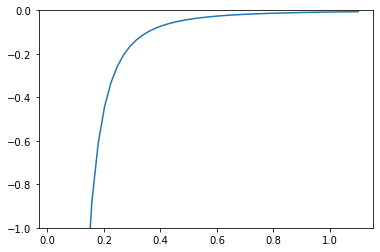

In [10]:
ys = linspace(0,1.1,50)
res = zeros(50)
for i, y in enumerate(ys):
    res[i]= pfn.normal_flow_residual(y, 0.0001, -1.43069, 1.)
figure()
plot(ys, res)
ylim(-1,0)

Node net fluxes =  [ 0.11359302  0.09666187  0.04347708  0.00412427 -0.00325806  0.00112432
  0.0007228   0.00052573]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           0.70312992   0.77534342   0.84503732   0.87053768
   0.86850559   0.86701416   0.87000975   0.87222134   0.87496315
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Discharge= [ 0.01359302  0.11025489  0.15373197  0.15785624  0.15459818  0.15572251
  0.15644531  0.15697103]
D_H= [ 1.1703117   1.22177917  1.24271665  1.24271665  1.24726153  1.25925732
  1.26590329  1.27270778]


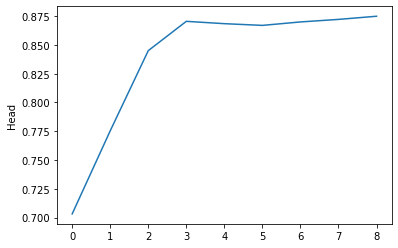

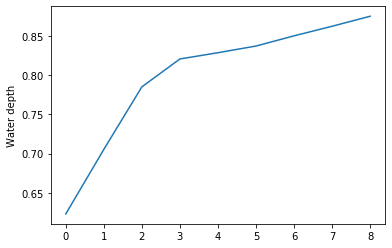

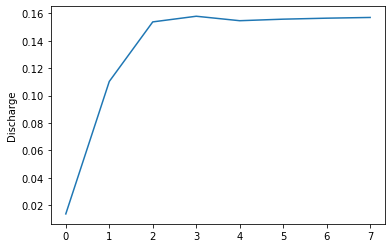

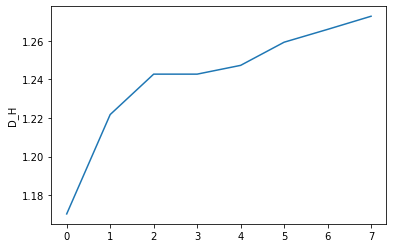

In [5]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",mg.at_node['hydraulic__head'])

figure()
plot(mg.at_node['hydraulic__head'][11:20])
ylabel('Head')

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')



print('Discharge=',Q[mg.active_links])
print('D_H=',mg.at_link['hydraulic__diameter'][mg.active_links])

Need to think about downstream bndy cond. It can produce some weird effects to have an artificially low fixed head boundary. 

For fully open channel solution iteration seems to get stuck with low dQ before head ever reaches appropriate range. 

In [9]:
print(mg.open_boundary_nodes)
print(mg.fixed_value_boundary_nodes)

[10 19 20 29 30 39]
[10 19 20 29 30 39]


In [36]:
heads_at_open_boundaries = mg.at_node['hydraulic__head'][mg.open_boundary_nodes]

mg.links_at_node[mg.open_boundary_nodes]
print(h)
upwind_links = mg.upwind_links_at_node(-Q)[mg.open_boundary_nodes]
#boundary_nodes_with_upwind_links = mg.open_boundary_nodes[upwind_links>0]
#upwind_links = upwind_links[upwind_links>0]
print(upwind_links)
#print(boundary_nodes_with_upwind_links)

for i, row in enumerate(upwind_links):
    print (row)
    bnd_node = mg.open_boundary_nodes[i]
    boundary_link = row[row>0]
    link_nodes = mg.nodes_at_link[boundary_link]
    upstream_node = link_nodes[link_nodes != bnd_node]
    equiv_upstream_flow_depth = mg.at_node['hydraulic__head'][upstream_node] - mg.at_node['junction__elevation'][upstream_node]
    mg.at_node['hydraulic__head'][bnd_node] = equiv_upstream_flow_depth

    #    if equiv_upstream_flow_depth>mg.at_link['maximum__depth'][boundary_link]:
        #If full pipe, set downstream head equal height above elevation
#        mg.at_node['hydraulic__head'][bnd_node] = equiv_upstream_flow_depth
    #Otherwise, solve for normal flow depth
        


[ 0.          0.          0.          0.          0.          4.2
  3.20179234  2.22153437  1.21065373  0.          4.2         3.20179761
  2.23520485  1.21146148  0.          4.2         3.20179234  2.22153437
  1.21065373  0.          0.          0.          0.          0.
  0.        ]
[[ 9 -1 -1]
 [-1 -1 -1]
 [18 -1 -1]
 [-1 -1 -1]
 [27 -1 -1]
 [-1 -1 -1]]
[ 9 -1 -1]
5
[-1 -1 -1]
9
[18 -1 -1]
10
[-1 -1 -1]
14
[27 -1 -1]
15
[-1 -1 -1]
19


array([ 9, -1, -1])

In [20]:
mg = RasterModelGrid((5,5),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.


w = mg.add_zeros('link','width')
mg.at_link['width']= 0.5*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = w

mg.at_node['input__discharge'][12]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= w#mg.at_link['hydraulic__diameter']#applicable for square conduits



#set heads at edges
h[mg.nodes_at_left_edge] = 4.2
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)


pfn = PresFlowNetwork(mg)


Number of links =  40
Number of nodes =  25
Number of active links =  18
Number of core nodes =  9


In [8]:
mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes]

array([  1.50350309e-01,   1.95539803e-09,   8.41032719e-02,
         1.50350310e-01,  -5.00000011e-02,   8.41032727e-02,
         1.50350309e-01,   1.95539803e-09,   8.41032719e-02])

In [21]:
for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=5.)

Time iteration: 0
max change in h:  0.00624999846719
max change in h:  0.00312499998806
max change in h:  0.00156250035591
max change in h:  0.000781250332019
max change in h:  0.000390625209346
max change in h:  0.000195312607906
max change in h:  0.000675557188024
max change in h:  0.00305957032746
max change in h:  0.0105381863919
max change in h:  0.00725064368962
max change in h:  0.0041586203004
max change in h:  0.00222711783631
max change in h:  0.00115316599532
max change in h:  0.000586228797804
max change in h:  0.000294910608406
max change in h:  0.000147451708341
max change in h:  7.34562679073e-05
average dh= 0.0129024910041   average abs(dQ)= 0.0202490671414
Time iteration: 1
max change in h:  0.0183385479768
max change in h:  0.00936328553833
max change in h:  0.00471649483183
max change in h:  0.00235976505261
max change in h:  0.00117653968185
max change in h:  0.000585544663148
max change in h:  0.000291141915632
max change in h:  0.0001446891683
max change in h:  7.

max change in h:  0.00114275701644
max change in h:  0.000567247749253
max change in h:  0.000281553800715
max change in h:  0.000139744038729
max change in h:  6.93579033637e-05
average dh= 0.0277831768403   average abs(dQ)= 0.000363688020443
Time iteration: 21
max change in h:  0.0184983326994
max change in h:  0.00919559514918
max change in h:  0.00456769356744
max change in h:  0.00226793248017
max change in h:  0.00112579906238
max change in h:  0.000558772058395
max change in h:  0.000277317196227
max change in h:  0.000137626259291
max change in h:  6.82992629502e-05
average dh= 0.0274201741593   average abs(dQ)= 0.000363688026154
Time iteration: 22
max change in h:  0.0182260564411
max change in h:  0.00905961690631
max change in h:  0.00449977504786
max change in h:  0.00223400000523
max change in h:  0.00110884240104
max change in h:  0.000550297149648
max change in h:  0.000273081035665
max change in h:  0.000135508722703
max change in h:  6.72407526761e-05
average dh= 0.027

max change in h:  0.000127836981795
max change in h:  6.55436226999e-05
average dh= 0.019511763073   average abs(dQ)= 0.00402426878871
Time iteration: 44
max change in h:  0.0124744092639
max change in h:  0.00665698927516
max change in h:  0.00353972587685
max change in h:  0.00186753077877
max change in h:  0.000976142608598
max change in h:  0.000505471630082
max change in h:  0.000259508064442
max change in h:  0.000132240058352
max change in h:  6.69678416965e-05
average dh= 0.0192652219069   average abs(dQ)= 0.00339019094257
Time iteration: 45
max change in h:  0.0144787256196
max change in h:  0.0075188680498
max change in h:  0.00389391161919
max change in h:  0.00200652575673
max change in h:  0.00102795445341
max change in h:  0.000523587370316
max change in h:  0.000265282899267
max change in h:  0.000133797638694
max change in h:  6.72280338014e-05
average dh= 0.019083036097   average abs(dQ)= 0.00240031909813
Time iteration: 46
max change in h:  0.0158742108638
max change 

max change in h:  0.000515149223876
max change in h:  0.000256726617614
max change in h:  0.000127949445962
max change in h:  6.37730645798e-05
average dh= 0.0185969337162   average abs(dQ)= 0.000195475751501
Time iteration: 69
max change in h:  0.016626187639
max change in h:  0.00828873513056
max change in h:  0.00413028117283
max change in h:  0.00205762779609
max change in h:  0.00102499126866
max change in h:  0.00051060382037
max change in h:  0.000254379625919
max change in h:  0.000126742954711
max change in h:  6.31549865293e-05
average dh= 0.0185866487918   average abs(dQ)= 0.000219333657171
Time iteration: 70
max change in h:  0.0164961775678
max change in h:  0.00822119816445
max change in h:  0.00409509904709
max change in h:  0.00203930521251
max change in h:  0.00101546926291
max change in h:  0.000505670311484
max change in h:  0.000251831795962
max change in h:  0.000125431182755
max change in h:  6.24813786725e-05
average dh= 0.0185759373666   average abs(dQ)= 0.00024

max change in h:  0.00411741938194
max change in h:  0.00204445119633
max change in h:  0.00101467830705
max change in h:  0.00050356701972
max change in h:  0.000249965160503
max change in h:  0.000124124883591
max change in h:  6.16621061521e-05
average dh= 0.0155927524962   average abs(dQ)= 0.000223921718299
Time iteration: 95
max change in h:  0.0165154468922
max change in h:  0.00821152788463
max change in h:  0.0040771305098
max change in h:  0.00202276759361
max change in h:  0.00100323151094
max change in h:  0.000497581994834
max change in h:  0.000246847558265
max change in h:  0.000122501932358
max change in h:  6.08167441827e-05
average dh= 0.0155048337475   average abs(dQ)= 0.000262361185975
Time iteration: 96
max change in h:  0.0162958651115
max change in h:  0.00809749598732
max change in h:  0.00401880139825
max change in h:  0.00199307009832
max change in h:  0.000988079840472
max change in h:  0.00048980669829
max change in h:  0.000242829529484
max change in h:  0.0

max change in h:  5.18868600974e-07
average dh= 5.22771629656e-09   average abs(dQ)= 1.36113815666e-06
Time iteration: 150
max change in h:  1.81997778848e-07
average dh= 5.41415793367e-09   average abs(dQ)= 1.03010062423e-06
Time iteration: 151
max change in h:  1.98694293685e-07
average dh= 5.18237330597e-09   average abs(dQ)= 6.97915387604e-07
Time iteration: 152
max change in h:  6.21893939901e-07
average dh= 4.65942713162e-09   average abs(dQ)= 3.8792646704e-07
Time iteration: 153
max change in h:  9.12159153321e-07
average dh= 3.95214363686e-09   average abs(dQ)= 3.69857936587e-07
Time iteration: 154
max change in h:  1.07783776282e-06
average dh= 3.14896521972e-09   average abs(dQ)= 4.7823822375e-07
Time iteration: 155
max change in h:  1.13398737822e-06
average dh= 2.32172574287e-09   average abs(dQ)= 5.39726362718e-07
Time iteration: 156
max change in h:  1.09994582864e-06
average dh= 1.52710770345e-09   average abs(dQ)= 5.50583620189e-07
Time iteration: 157
max change in h:  

max change in h:  3.42510464435e-11
average dh= -1.72743980578e-13   average abs(dQ)= 4.61250603292e-11
Time iteration: 236
max change in h:  1.06814557199e-11
average dh= -1.78537966625e-13   average abs(dQ)= 3.43838696408e-11
Time iteration: 237
max change in h:  4.1795455985e-12
average dh= -1.70455707805e-13   average abs(dQ)= 2.27051192141e-11
Time iteration: 238
max change in h:  1.14801501638e-11
average dh= -1.5202444049e-13   average abs(dQ)= 1.2587245473e-11
Time iteration: 239
max change in h:  1.64157576421e-11
average dh= -1.2674897108e-13   average abs(dQ)= 1.34352759826e-11
Time iteration: 240
max change in h:  1.91398008553e-11
average dh= -9.78689419244e-14   average abs(dQ)= 1.72925103749e-11
Time iteration: 241
max change in h:  1.99298355597e-11
average dh= -6.81959195904e-14   average abs(dQ)= 1.91530201258e-11
Time iteration: 242
max change in h:  1.91409110784e-11
average dh= -4.00032167885e-14   average abs(dQ)= 1.92620882051e-11
Time iteration: 243
max change i

max change in h:  8.881784197e-16
average dh= 4.19976553534e-17   average abs(dQ)= 5.53468644854e-16
Time iteration: 331
max change in h:  6.66133814775e-16
average dh= 3.20239591018e-17   average abs(dQ)= 4.96410999691e-16
Time iteration: 332
max change in h:  4.4408920985e-16
average dh= 2.2505145895e-17   average abs(dQ)= 3.88037463369e-16
Time iteration: 333
max change in h:  2.22044604925e-16
average dh= 1.55469772858e-17   average abs(dQ)= 3.21560811832e-16
Time iteration: 334
max change in h:  0.0
average dh= 8.14067177865e-18   average abs(dQ)= 2.24337993687e-16
Time iteration: 335
max change in h:  2.22044604925e-16
average dh= -9.55061647052e-19   average abs(dQ)= 1.45067756515e-16
Time iteration: 336
max change in h:  2.22044604925e-16
average dh= -1.03823200037e-17   average abs(dQ)= 8.98698192446e-17
Time iteration: 337
max change in h:  0.0
average dh= -2.48585874107e-17   average abs(dQ)= 1.19278803173e-16
Time iteration: 338
max change in h:  0.0
average dh= -3.92741394

max change in h:  0.0
average dh= -3.89850189168e-17   average abs(dQ)= 9.42352388252e-18
Time iteration: 421
max change in h:  0.0
average dh= -3.93049790246e-17   average abs(dQ)= 9.39641882821e-18
Time iteration: 422
max change in h:  0.0
average dh= -3.91459627059e-17   average abs(dQ)= 9.39039548281e-18
Time iteration: 423
max change in h:  0.0
average dh= -3.90023661515e-17   average abs(dQ)= 9.3843721374e-18
Time iteration: 424
max change in h:  0.0
average dh= -3.88587695971e-17   average abs(dQ)= 9.37985462835e-18
Time iteration: 425
max change in h:  0.0
average dh= -3.86987895432e-17   average abs(dQ)= 9.3753371193e-18
Time iteration: 426
max change in h:  0.0
average dh= -3.90486254442e-17   average abs(dQ)= 9.3693137739e-18
Time iteration: 427
max change in h:  0.0
average dh= -3.93994250805e-17   average abs(dQ)= 9.36630210119e-18
Time iteration: 428
max change in h:  0.0
average dh= -3.92558285261e-17   average abs(dQ)= 9.31058615622e-18
Time iteration: 429
max change in

In [10]:
#h_new_solver = h.copy()
#Q_new_solver = Q.copy()
#h[mg.core_nodes]
#mg.at_link['hydraulic__diameter']
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])

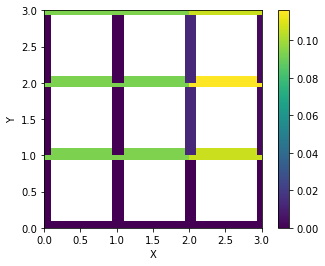

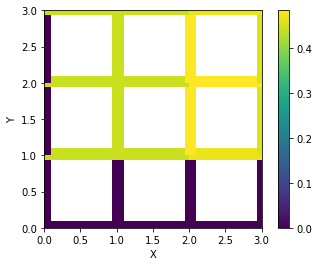

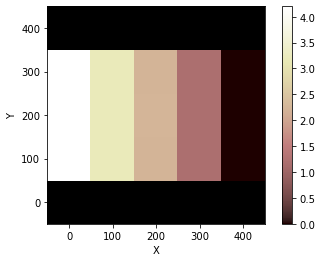

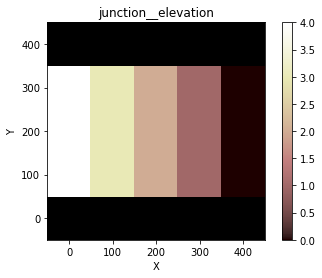

In [15]:
figure()
plot_links(mg, 'conduit__discharge',magnitude=True)
figure()
plot_links(mg, 'hydraulic__diameter')
figure()
imshow_grid_at_node(mg, h)
figure()
imshow_grid_at_node(mg, 'junction__elevation')


In [9]:
FUDGE=0.0001
active_links = mg.active_links
head_nodes = mg.node_at_link_head[active_links]
tail_nodes = mg.node_at_link_tail[active_links]
h_head = mg.at_node['hydraulic__head'][head_nodes]
h_tail = mg.at_node['hydraulic__head'][tail_nodes]
#Calculate flow depths using offset and junction elevations
y_head = h_head - mg.at_node['junction__elevation'][head_nodes] \
         - mg.at_link['conduit_head__offset'][active_links]
y_tail = h_tail - mg.at_node['junction__elevation'][tail_nodes] \
          - mg.at_link['conduit_tail__offset'][active_links]
y_head[y_head>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_head>mg.at_link['maximum__depth'][active_links]]
y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
y_avg = 0.5*(y_head + y_tail)
A_avg = mg.at_link['width'][active_links] * y_avg
y_avg[y_avg<FUDGE] = FUDGE
A_avg[A_avg<FUDGE] = FUDGE

In [10]:
h_head>h_tail

array([False, False, False, False, False, False, False, False, False], dtype=bool)

In [22]:
#y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = 
#mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
d_h_square(mg.at_link['width'][active_links], y_avg)

array([  3.96936126e-01,   3.53636005e-04,   3.99594057e-04,
         3.99687423e-04,   3.99814040e-04,   3.99715864e-04,
         3.99694894e-04,   4.90132384e-01,   3.99793756e-04,
         3.96927434e-04,   3.99777355e-04,   3.99802869e-04,
         3.99787176e-04,   3.97200621e-04,   2.81319838e-01,
         3.99646193e-04,   3.99446218e-04,   3.99054260e-04])

In [21]:
def d_h_square(width, flow_depth):
    d_H = np.zeros(np.size(width))
    is_full_pipe = np.isclose(width,flow_depth)
    d_H[is_full_pipe] = width[is_full_pipe]
    d_H[~is_full_pipe] = 4.*width[~is_full_pipe]*flow_depth[~is_full_pipe] / (2.*flow_depth[~is_full_pipe] + width[~is_full_pipe])
    return d_H

In [17]:
mg.at_link['hydraulic__diameter'][mg.active_links]

array([ 0.75,  0.75,  0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,
        0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.5 ])

In [11]:
pfn.run_one_step()

Number of iterations = 1 tolerance = nan  iteration time= 0.016219377517700195


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:186: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:267: RuntimeWarning: divide by zero encountered in double_scalars
  ADA_ij[i][j] = -1./(a[this_link]*r[this_link]*np.fabs(self.Q[this_link])**(a[this_link]-1))
/home/mcoving/anaconda3/envs/landlab_dev/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:277: RuntimeWarning: divide by zero encountered in true_divide
  dQ= -(1./a[self.grid.active_links])*self.Q[self.grid.active_links] - 1./(a[self.grid.active_links]*r[self.grid.active_links]*np.fabs(self.Q[self.grid.active_links])**(a[self.grid.active_link

In [5]:
d_h.copy()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [54]:
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])